In [28]:
# Import the pandas_market_calendars module
%pip install pandas_market_calendars
import pandas_market_calendars as mcal

from datetime import datetime
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pandas.plotting import lag_plot

Note: you may need to restart the kernel to use updated packages.


In [57]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_ruble_data.csv")
data.tail()

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.4256,14260.0,67.83,8.2,3.300000e+09,8.14
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.3466,14260.0,67.83,8.2,3.300000e+09,8.14
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.1045,14260.0,67.83,8.2,3.300000e+09,8.14
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.2548,14260.0,67.83,8.2,3.300000e+09,8.14
7669,80.7498,2025-08-22,2025,3,8,22,5,False,0.616786,post,80.7498,14260.0,67.83,8.2,3.300000e+09,8.14


### Missing Values

In [58]:
data.isnull().sum()

currency_rate           0
date                    0
year                    0
quarter                 0
month                   0
day                     0
dow                     0
weekend                 0
currency_rate_change    1
denomination            0
RUB                     0
GDP_per_capita          0
Brent_price             0
GDP_deflator            0
FD_investment           0
Inflation               0
dtype: int64

### Exploratory Data Analysis (EDA)

In [59]:
shocks = {
    "1998 Default": "1998-08-17",
    "2008 GFC": "2008-09-15",
    "2014 Crimea": "2014-03-01",
    "2020 COVID": "2020-03-11",
    "2022 Invasion": "2022-02-24"
}

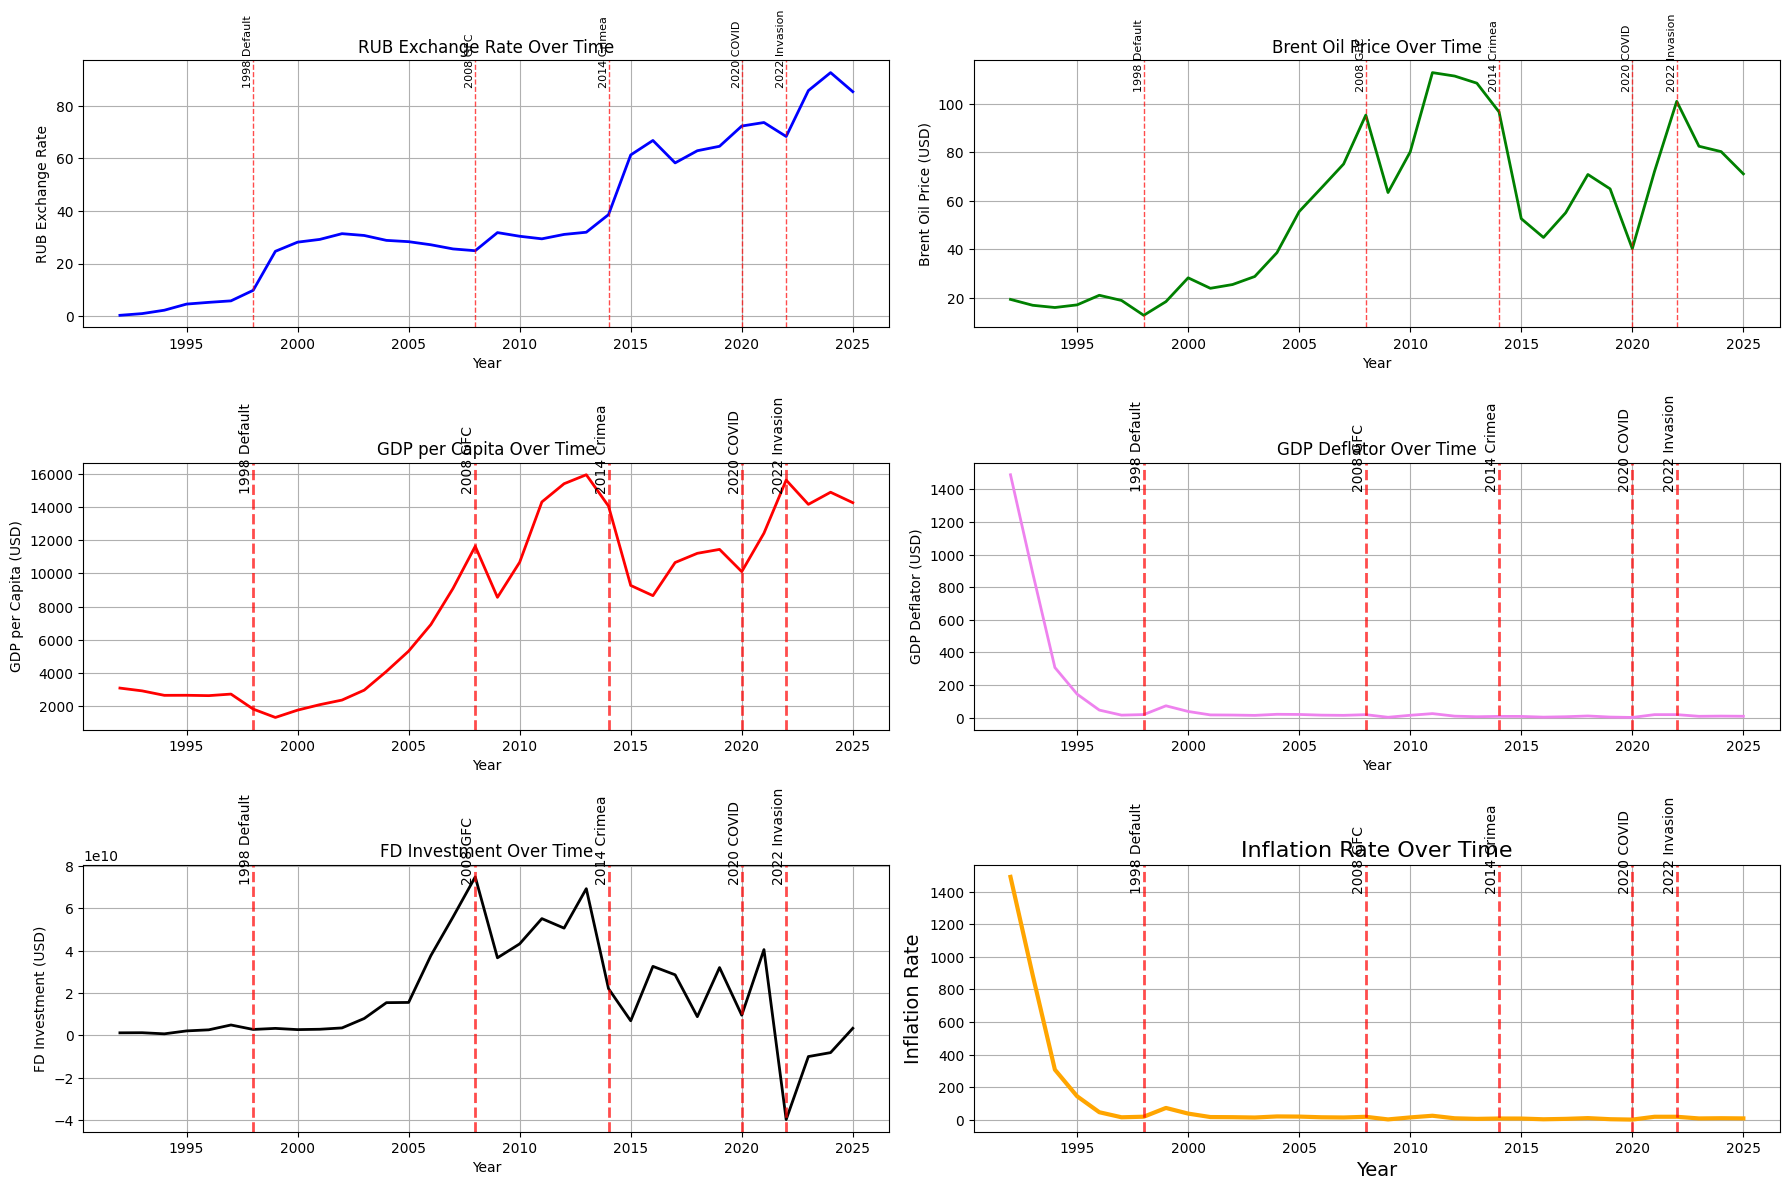

In [60]:
plt.figure(figsize=(18, 12))

# 1. RUB over time
plt.subplot(3, 2, 1)
data.groupby('year')['RUB'].mean().plot(title='RUB Exchange Rate Over Time', color='blue', linewidth=2)
plt.xlabel('Year')
plt.ylabel('RUB Exchange Rate')
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=1)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=8, ha='right')

# 2. Brent price
plt.subplot(3, 2, 2)
data.groupby('year')['Brent_price'].mean().plot(title='Brent Oil Price Over Time', color='green', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Brent Oil Price (USD)')
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=1)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=8, ha='right')

# 3. GDP per capita
plt.subplot(3, 2, 3)
data.groupby('year')['GDP_per_capita'].mean().plot(title='GDP per Capita Over Time', color='red', linewidth=2)
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

# 4. GDP Deflator
plt.subplot(3, 2, 4)
data.groupby('year')['GDP_deflator'].mean().plot(title='GDP Deflator Over Time', color='violet', linewidth=2)
plt.xlabel('Year')
plt.ylabel('GDP Deflator (USD)')
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

# 5. FD Investment
plt.subplot(3, 2, 5)
data.groupby('year')['FD_investment'].mean().plot(title='FD Investment Over Time', color='black', linewidth=2)
plt.xlabel('Year')
plt.ylabel('FD Investment (USD)')
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

# 6. Inflation
plt.subplot(3, 2, 6)
data.groupby('year')['Inflation'].mean().plot(title='Inflation Rate Over Time', color='orange', linewidth=3)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inflation Rate', fontsize=14)
plt.title('Inflation Rate Over Time', fontsize=16)
plt.grid(True)
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in data['year'].values:
        plt.axvline(x=shock_year, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*0.9, shock_name, rotation=90, fontsize=10, ha='right')

plt.tight_layout()
plt.show()

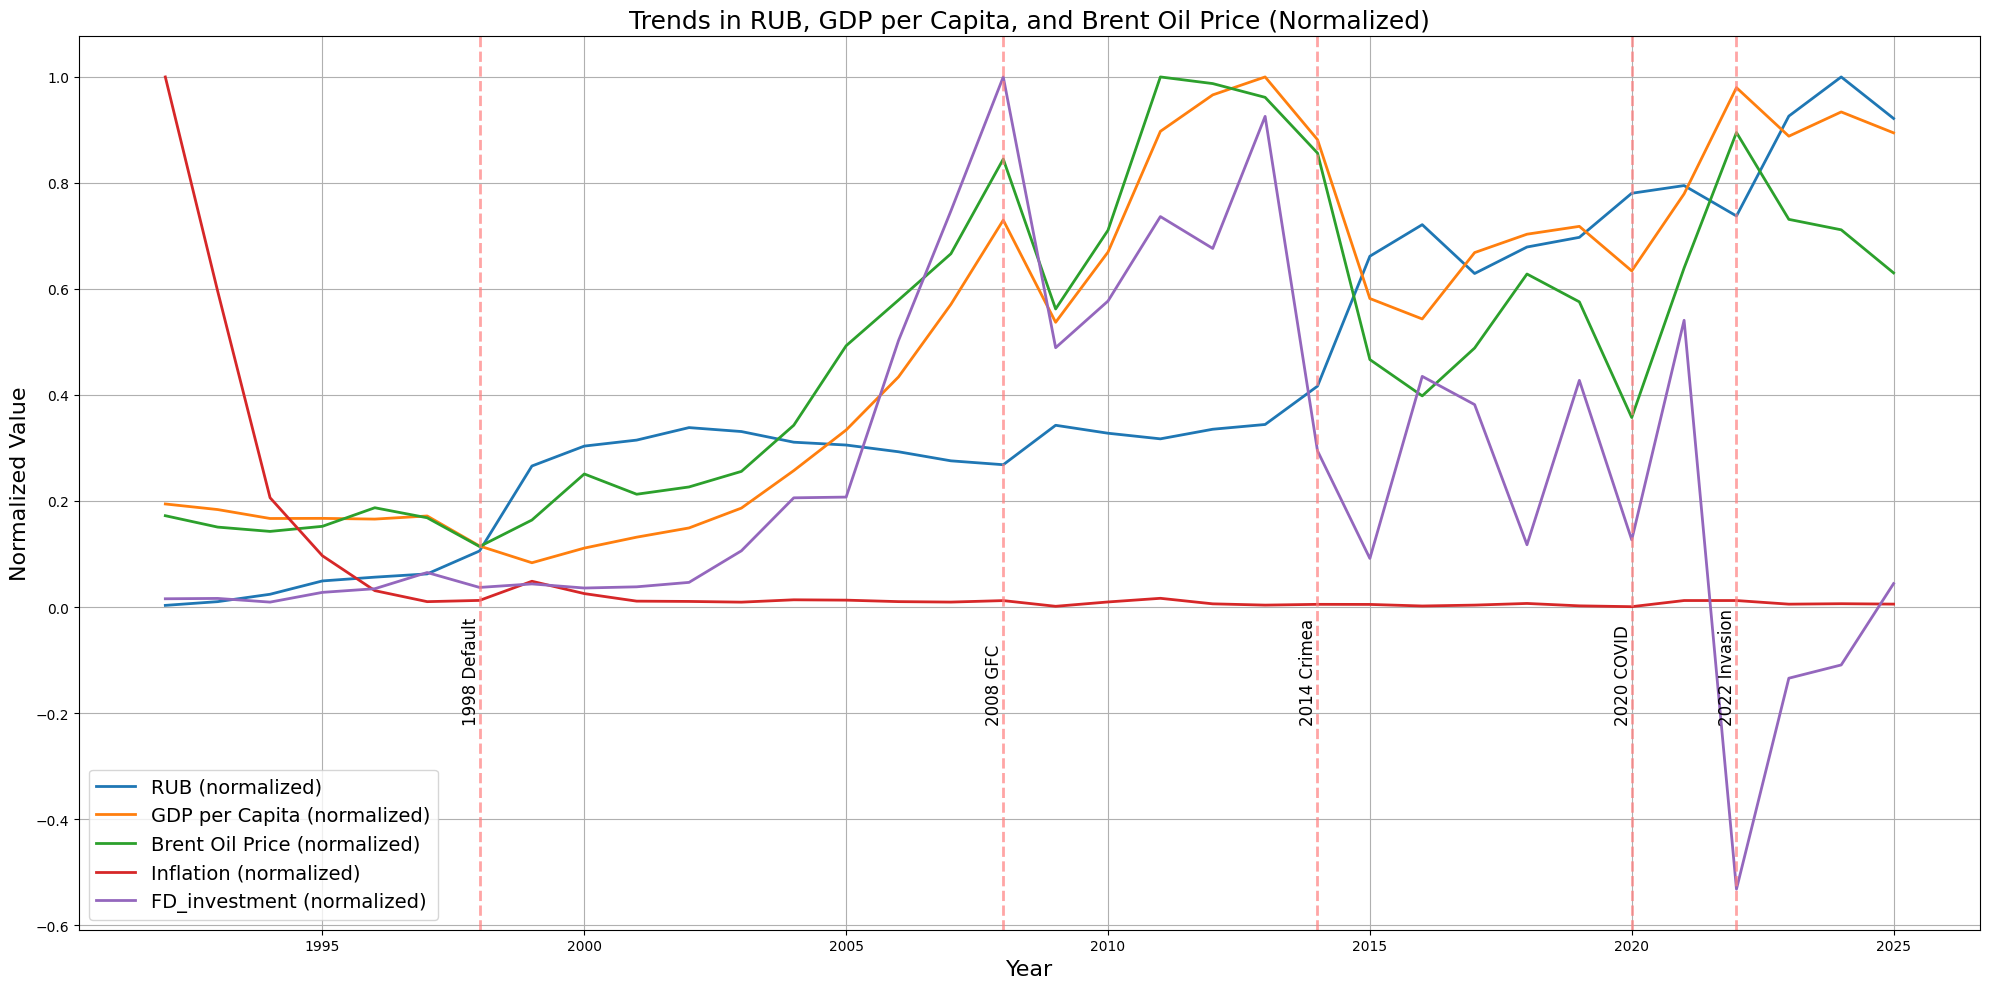

In [79]:
annual_data = data.groupby("year").agg({
    "RUB": "mean",
    "GDP_per_capita": "mean",
    "Brent_price": "mean", 
    "Inflation": "mean",
    "FD_investment": "mean",
}).reset_index()

annual_data["RUB_norm"] = annual_data["RUB"] / annual_data["RUB"].max()
annual_data["GDP_norm"] = annual_data["GDP_per_capita"] / annual_data["GDP_per_capita"].max()
annual_data["Brent_norm"] = annual_data["Brent_price"] / annual_data["Brent_price"].max()
annual_data["Infl_norm"] = annual_data["Inflation"] / annual_data["Inflation"].max()
annual_data["FD_norm"] = annual_data["FD_investment"] / annual_data["FD_investment"].max()

plt.figure(figsize=(20, 10))  # Increased figure size for better fit
plt.plot(annual_data["year"], annual_data["RUB_norm"], label="RUB (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["GDP_norm"], label="GDP per Capita (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Brent_norm"], label="Brent Oil Price (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["Infl_norm"], label="Inflation (normalized)", linewidth=2)
plt.plot(annual_data["year"], annual_data["FD_norm"], label="FD_investment (normalized)", linewidth=2)

# Add shocks as vertical lines and labels
for shock_name, shock_date in shocks.items():
    shock_year = pd.to_datetime(shock_date).year
    if shock_year in annual_data["year"].values:
        plt.axvline(x=shock_year, color='#FF7F7F', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(shock_year, plt.ylim()[1]*-0.2, shock_name, rotation=90, fontsize=12, ha='right')

plt.title("Trends in RUB, GDP per Capita, and Brent Oil Price (Normalized)", fontsize=18)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Normalized Value", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

plt.show()

#### Correlation heatmap

<Axes: >

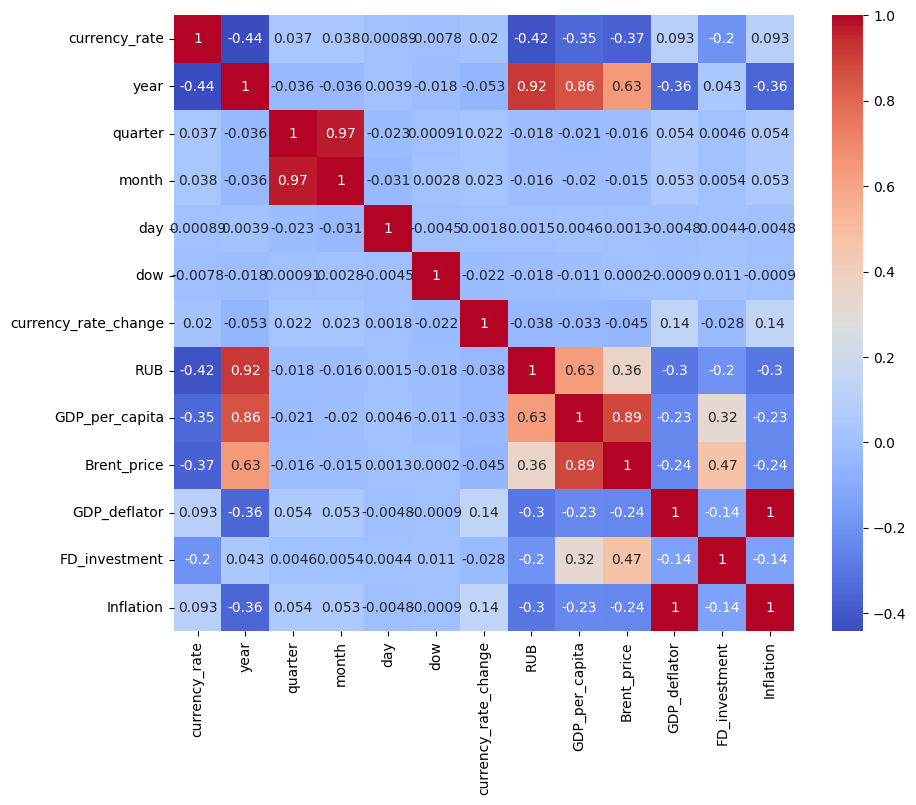

In [63]:
num_data = data.select_dtypes(include='number')
corr = num_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

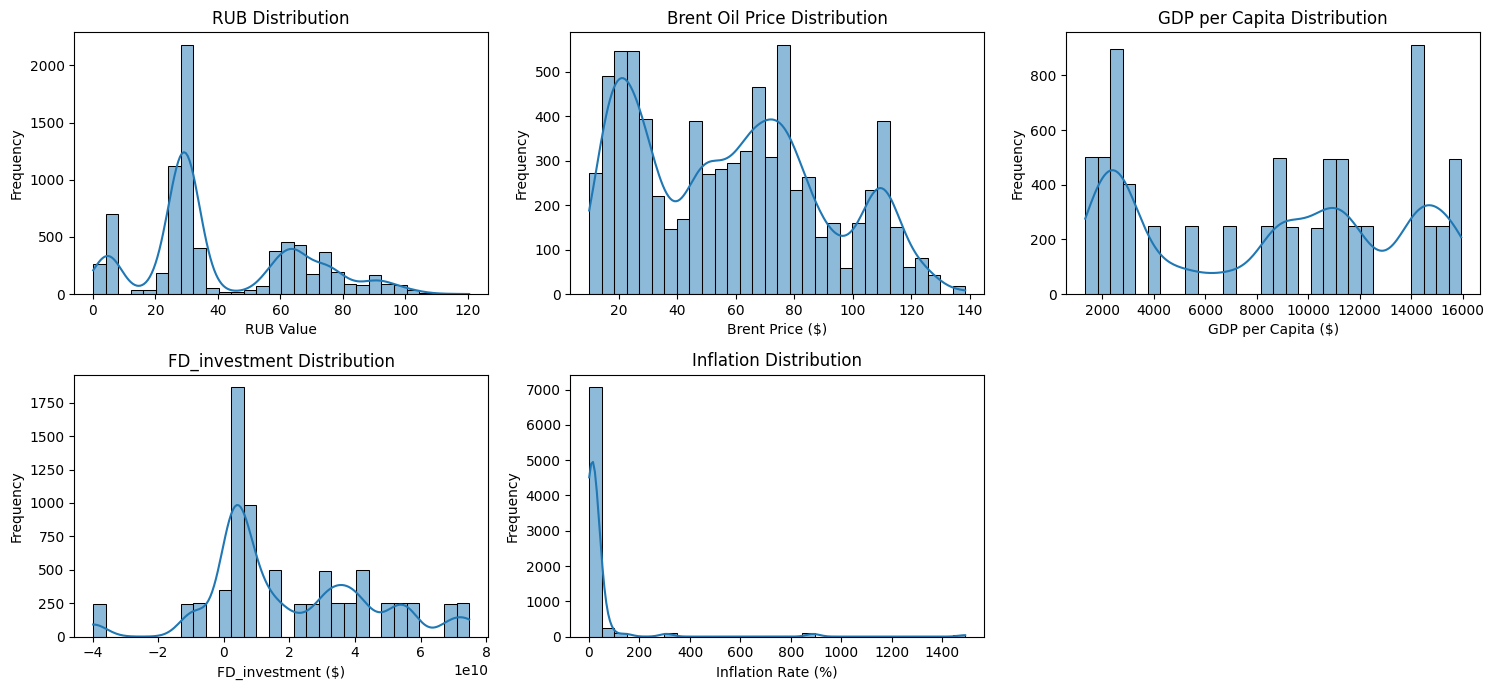

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))

sns.histplot(data['RUB'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('RUB Distribution')
axes[0,0].set_xlabel('RUB Value')
axes[0,0].set_ylabel('Frequency')

sns.histplot(data['Brent_price'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Brent Oil Price Distribution')
axes[0,1].set_xlabel('Brent Price ($)')
axes[0,1].set_ylabel('Frequency')

sns.histplot(data['GDP_per_capita'], bins=30, kde=True, ax=axes[0,2])
axes[0,2].set_title('GDP per Capita Distribution')
axes[0,2].set_xlabel('GDP per Capita ($)')
axes[0,2].set_ylabel('Frequency')

sns.histplot(data['FD_investment'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('FD_investment Distribution')
axes[1,0].set_xlabel('FD_investment ($)')
axes[1,0].set_ylabel('Frequency')

sns.histplot(data['Inflation'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Inflation Distribution')
axes[1,1].set_xlabel('Inflation Rate (%)')
axes[1,1].set_ylabel('Frequency')

# Hide the unused subplot (axes[1,2])
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


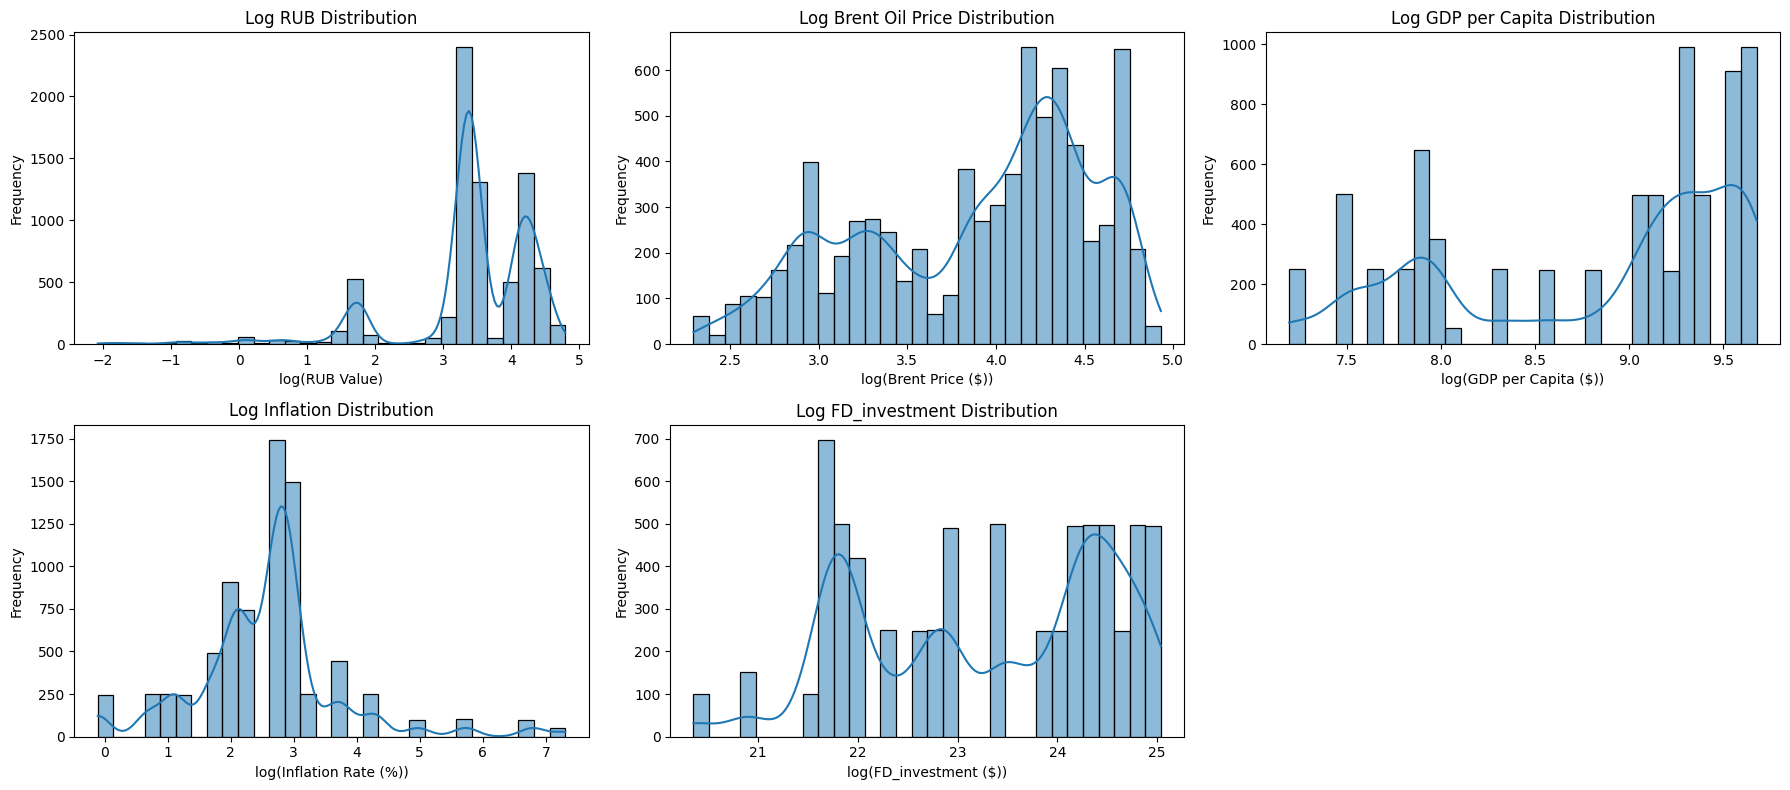

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

sns.histplot(np.log(data['RUB'].replace(0, np.nan).dropna()), bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title('Log RUB Distribution')
axes[0,0].set_xlabel('log(RUB Value)')
axes[0,0].set_ylabel('Frequency')

sns.histplot(np.log(data['Brent_price'].replace(0, np.nan).dropna()), bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title('Log Brent Oil Price Distribution')
axes[0,1].set_xlabel('log(Brent Price ($))')
axes[0,1].set_ylabel('Frequency')

sns.histplot(np.log(data['GDP_per_capita'].replace(0, np.nan).dropna()), bins=30, kde=True, ax=axes[0,2])
axes[0,2].set_title('Log GDP per Capita Distribution')
axes[0,2].set_xlabel('log(GDP per Capita ($))')
axes[0,2].set_ylabel('Frequency')

sns.histplot(np.log(data['Inflation'].replace(0, np.nan).dropna()), bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title('Log Inflation Distribution')
axes[1,0].set_xlabel('log(Inflation Rate (%))')
axes[1,0].set_ylabel('Frequency')

sns.histplot(np.log(data['FD_investment'].replace(0, np.nan).dropna()), bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title('Log FD_investment Distribution')
axes[1,1].set_xlabel('log(FD_investment ($))')
axes[1,1].set_ylabel('Frequency')

# Hide the unused subplot (axes[1,2])
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

### Descriptive Statistics

In [62]:
data.describe()

,currency_rate,year,quarter,month,day,dow,currency_rate_change,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation
count,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7670.000000,7669.000000,7670.000000,7670.000000,7670.000000,7670.000000,7.670000e+03,7670.000000
mean,464.412233,2009.638592,2.549674,6.655541,16.126467,4.002868,0.082222,40.684786,8572.722279,58.639331,42.715935,1.975617e+10,42.714613
std,1388.749361,9.026007,1.105857,3.393557,8.750473,1.410055,1.888115,25.050811,4951.677498,31.977625,160.131182,2.496022e+10,160.131467
min,5.960000,1992.000000,1.000000,1.000000,1.000000,1.000000,-99.900000,0.125260,1330.757202,9.910000,0.898246,-3.980094e+10,0.898246
25%,28.670200,2002.000000,2.000000,4.000000,9.000000,3.000000,-0.202429,27.068600,2930.670166,27.560000,7.490071,2.847300e+09,7.490071
50%,32.795300,2010.000000,3.000000,7.000000,16.000000,4.000000,0.010268,30.838700,9277.713867,59.090000,14.191110,9.478810e+09,14.191110
75%,72.388225,2017.000000,4.000000,10.000000,24.000000,5.000000,0.261026,63.116000,12425.029297,80.370000,18.538967,3.759477e+10,18.538967
max,5960.000000,2025.000000,4.000000,12.000000,31.000000,7.000000,38.581010,120.378500,15941.448242,138.400000,1490.418425,7.478291e+10,1490.418425


### Distribution

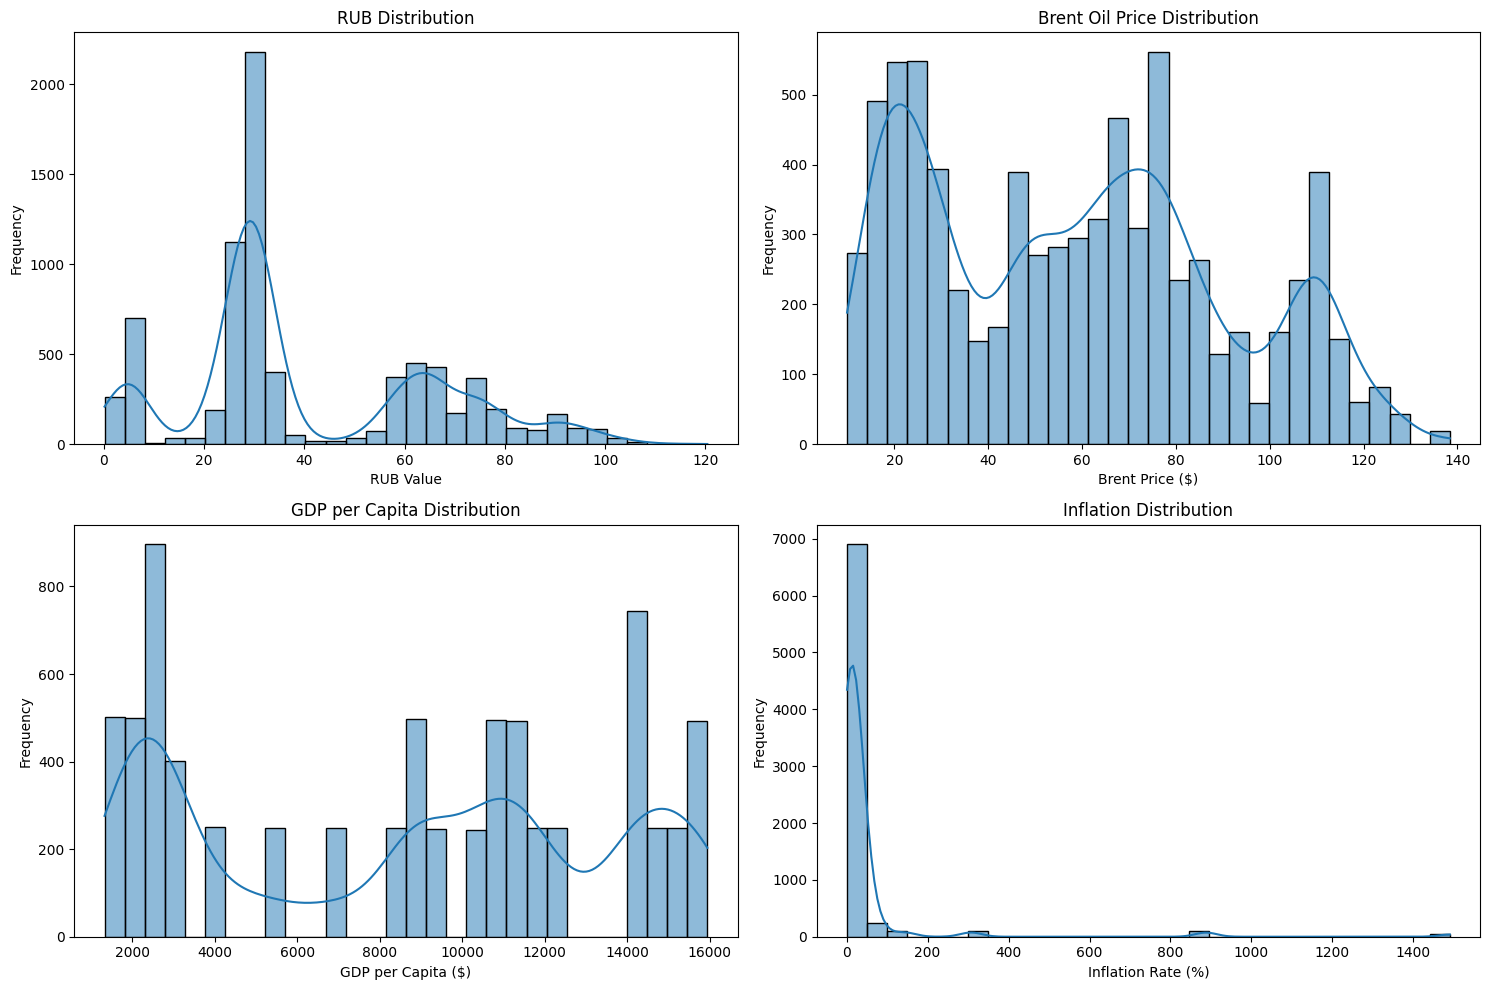

<Axes: >

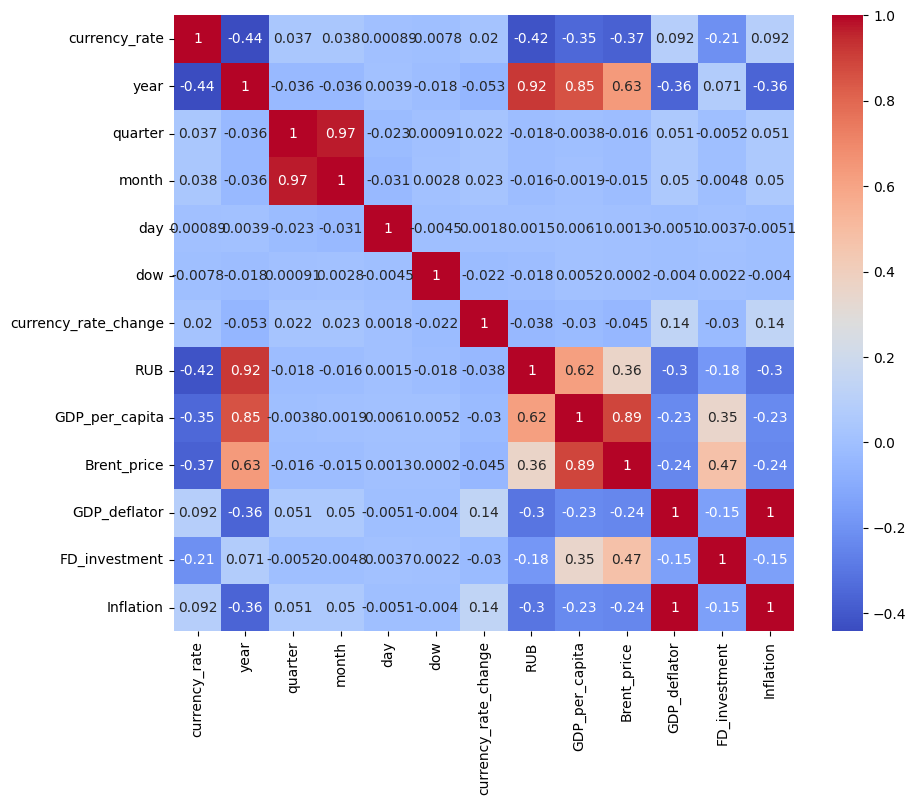

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

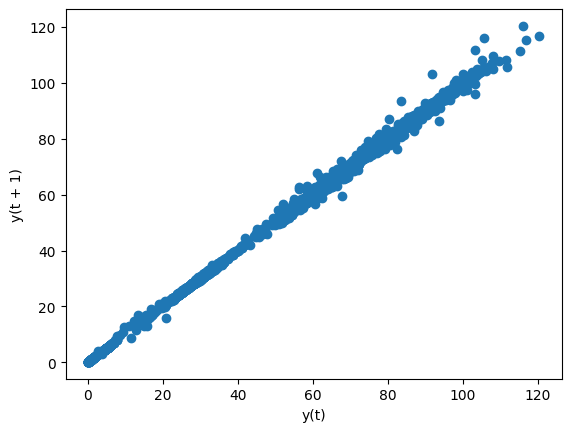

In [ ]:
# Rolling average of Brent
data['Brent_roll'] = data['Brent_price'].rolling(12).mean()
data['Brent_lag1'] = data['Brent_price'].shift(1)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

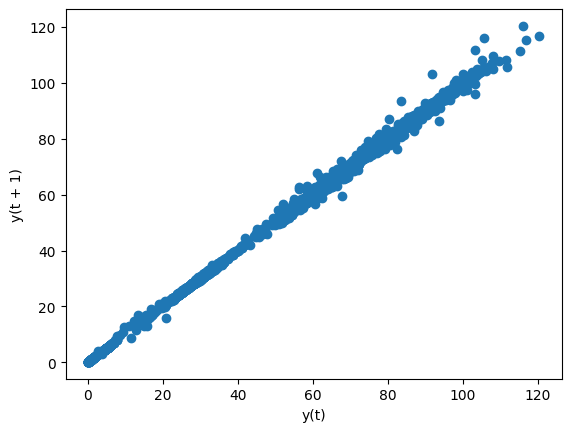

In [27]:
lag_plot(data['RUB'])

In [26]:
data

,currency_rate,date,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,RUB,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,Brent_roll,Brent_lag1
0,125.2600,1992-07-01,1992,3,7,1,3,False,NaN,pre,0.12526,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,NaN
1,134.8000,1992-07-03,1992,3,7,3,5,False,7.616158,pre,0.13480,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
2,130.5000,1992-07-08,1992,3,7,8,3,False,-3.189911,pre,0.13050,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
3,130.3000,1992-07-10,1992,3,7,10,5,False,-0.153257,pre,0.13030,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
4,130.2000,1992-07-15,1992,3,7,15,3,False,-0.076746,pre,0.13020,3098.802734,20.38,1490.418425,1.161000e+09,1490.418425,NaN,20.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,80.4256,2025-08-18,2025,3,8,18,1,False,0.503859,post,80.42560,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7666,80.3466,2025-08-19,2025,3,8,19,2,False,-0.098227,post,80.34660,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7667,80.1045,2025-08-20,2025,3,8,20,3,False,-0.301320,post,80.10450,NaN,67.83,NaN,NaN,NaN,67.83,67.83
7668,80.2548,2025-08-21,2025,3,8,21,4,False,0.187630,post,80.25480,NaN,67.83,NaN,NaN,NaN,67.83,67.83
